# Kubernetes Logs Data Preprocessing

This notebook performs comprehensive preprocessing on Kubernetes logs data for subsequent clustering analysis.

In [1]:
import pandas as pd
import numpy as np
import json
import gzip
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Data Loading and Initial Exploration

In [2]:
# Load the Kubernetes logs data
def load_kubernetes_logs(file_path):
    """Load and parse Kubernetes logs from JSONL format"""
    logs = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                log_entry = json.loads(line.strip())
                logs.append(log_entry)
            except json.JSONDecodeError as e:
                print(f"Skipping invalid JSON line: {e}")
                continue
    
    return logs

# Load the data
logs_file = 'output/kubernetes/logs_2024-01-01.jsonl'
print(f"Loading logs from {logs_file}...")
logs_data = load_kubernetes_logs(logs_file)
print(f"Loaded {len(logs_data)} log entries")

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(logs_data)
print(f"\nDataFrame shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

Loading logs from output/kubernetes/logs_2024-01-01.jsonl...
Loaded 57133 log entries

DataFrame shape: (57133, 4)

Columns: ['timestamp', 'stream', 'log', 'kubernetes']


In [3]:
# Display sample data
print("Sample log entries:")
df.head()

Sample log entries:


,timestamp,stream,log,kubernetes
0,2024-01-01T00:00:00Z,stdout,"2024-01-01 00:00:00,000 INFO [flask.app] P...","{'pod_name': 'notification-service-1-b02c8', '..."
1,2024-01-01T00:00:00Z,stderr,"2024-01-01 00:00:00,000 INFO [app.services...","{'pod_name': 'user-service-0-152ab', 'namespac..."
2,2024-01-01T00:00:00Z,stderr,2024-01-01 00:00:00 INFO PUT /orders/user/{use...,"{'pod_name': 'order-service-0-a8a76', 'namespa..."
3,2024-01-01T00:00:00.232946Z,stderr,"2024-01-01 00:00:00,232 INFO [uvicorn.acce...","{'pod_name': 'order-service-5-11111', 'namespa..."
4,2024-01-01T00:00:00.232946Z,stdout,"{""timestamp"": ""2024-01-01T00:00:00.232946"", ""l...","{'pod_name': 'order-service-5-11111', 'namespa..."


In [4]:
# Explore the structure of kubernetes metadata
if 'kubernetes' in df.columns:
    print("Kubernetes metadata structure:")
    k8s_sample = df['kubernetes'].iloc[0]
    for key, value in k8s_sample.items():
        print(f"  {key}: {value}")
else:
    print("No kubernetes metadata found")

Kubernetes metadata structure:
  pod_name: notification-service-1-b02c8
  namespace_name: production
  container_name: notification-service
  container_id: docker://b90ca3620969
  pod_id: 28e933b5-ef7f-4d72-92c5-1055739abd96
  labels: {'app': 'notification-service', 'version': 'v1.3.0', 'environment': 'production', 'tier': 'backend'}
  host: ip-35-214-27-191.b.compute.internal


## 2. Data Quality Assessment

In [5]:
# Check for missing values
print("Missing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nTotal missing values: {df.isnull().sum().sum()}")
print(f"Data completeness: {(1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100:.2f}%")

Missing values per column:
Series([], dtype: int64)

Total missing values: 0
Data completeness: 100.00%


Log level distribution:
log_level
INFO     46141
DEBUG     8160
ERROR     2832
Name: count, dtype: int64


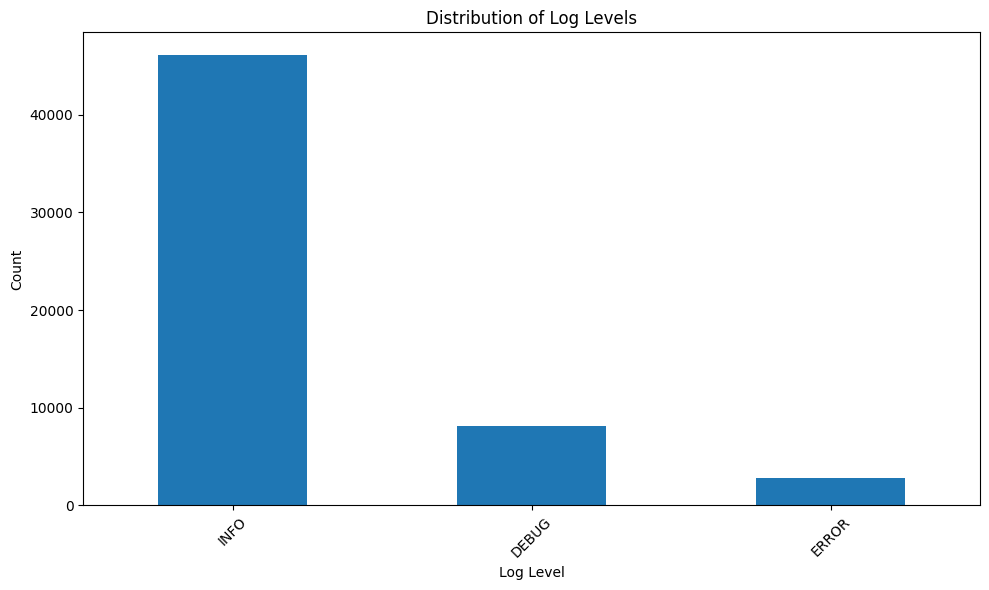

In [6]:
# Analyze log levels and patterns
def extract_log_level(log_message):
    """Extract log level from log message"""
    if pd.isna(log_message):
        return 'UNKNOWN'
    
    log_message = str(log_message).upper()
    
    if 'ERROR' in log_message:
        return 'ERROR'
    elif 'WARN' in log_message or 'WARNING' in log_message:
        return 'WARN'
    elif 'INFO' in log_message:
        return 'INFO'
    elif 'DEBUG' in log_message:
        return 'DEBUG'
    else:
        return 'OTHER'

# Extract log levels
df['log_level'] = df['log'].apply(extract_log_level)

print("Log level distribution:")
print(df['log_level'].value_counts())

# Visualize log level distribution
plt.figure(figsize=(10, 6))
df['log_level'].value_counts().plot(kind='bar')
plt.title('Distribution of Log Levels')
plt.xlabel('Log Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Analyze timestamp patterns
def parse_timestamp(timestamp_str):
    """Parse timestamp string to datetime"""
    try:
        return pd.to_datetime(timestamp_str)
    except:
        return pd.NaT

df['parsed_timestamp'] = df['timestamp'].apply(parse_timestamp)

print("Timestamp analysis:")
print(f"Valid timestamps: {df['parsed_timestamp'].notna().sum()}")
print(f"Invalid timestamps: {df['parsed_timestamp'].isna().sum()}")

if df['parsed_timestamp'].notna().sum() > 0:
    print(f"Time range: {df['parsed_timestamp'].min()} to {df['parsed_timestamp'].max()}")
    
    # Extract time features
    df['hour'] = df['parsed_timestamp'].dt.hour
    df['day_of_week'] = df['parsed_timestamp'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6])
    
    print("\nHourly distribution:")
    print(df['hour'].value_counts().sort_index())

Timestamp analysis:
Valid timestamps: 57133
Invalid timestamps: 0
Time range: 2024-01-01 00:00:00+00:00 to 2024-01-01 00:59:59.977977+00:00

Hourly distribution:
hour
0    57133
Name: count, dtype: int64


## 3. Data Cleaning and Normalization

In [8]:
# Clean and normalize log messages
def clean_log_message(log_message):
    """Clean and normalize log messages"""
    if pd.isna(log_message):
        return ""
    
    log_msg = str(log_message)
    
    # Remove timestamps from log messages (if they appear to be at the beginning)
    log_msg = re.sub(r'^\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}[,\.\d]*\s*', '', log_msg)
    
    # Normalize whitespace
    log_msg = re.sub(r'\s+', ' ', log_msg).strip()
    
    # Remove special characters that might interfere with analysis
    log_msg = re.sub(r'[^\w\s\-\.\:\/\(\)\[\]\{\}\=\<\>\|\&\;\,\%\+\*\#\@]', ' ', log_msg)
    
    return log_msg.lower()

# Apply cleaning
df['cleaned_log'] = df['log'].apply(clean_log_message)

print("Log message cleaning completed")
print(f"\nSample cleaned logs:")
for i in range(min(5, len(df))):
    print(f"Original: {df['log'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['cleaned_log'].iloc[i][:100]}...")
    print()

Log message cleaning completed

Sample cleaned logs:
Original: 2024-01-01 00:00:00,000 INFO     [flask.app] PUT /notifications 200 49.17ms...
Cleaned:  info [flask.app] put /notifications 200 49.17ms...

Original: 2024-01-01 00:00:00,000 INFO     [app.services.user] PUT /users/{id}/profile 200 94.29ms...
Cleaned:  info [app.services.user] put /users/{id}/profile 200 94.29ms...

Original: 2024-01-01 00:00:00 INFO PUT /orders/user/{userId} 200 29.00ms...
Cleaned:  info put /orders/user/{userid} 200 29.00ms...

Original: 2024-01-01 00:00:00,232 INFO     [uvicorn.access] Health check passed...
Cleaned:  info [uvicorn.access] health check passed...

Original: {"timestamp": "2024-01-01T00:00:00.232946", "level": "INFO", "message": "PUT /orders/user/{userId} 2...
Cleaned:  { timestamp :  2024-01-01t00:00:00.232946 ,  level :  info ,  message :  put /orders/user/{userid} 2...



In [9]:
# Extract structured data from kubernetes metadata
def extract_k8s_features(k8s_data):
    """Extract features from kubernetes metadata"""
    if pd.isna(k8s_data) or not isinstance(k8s_data, dict):
        return {}
    
    features = {}
    
    # Extract pod and container information
    features['pod_name'] = k8s_data.get('pod_name', '')
    features['namespace_name'] = k8s_data.get('namespace_name', '')
    features['container_name'] = k8s_data.get('container_name', '')
    features['host'] = k8s_data.get('host', '')
    
    # Extract labels (flatten the labels dictionary)
    labels = k8s_data.get('labels', {})
    if isinstance(labels, dict):
        for label_key, label_value in labels.items():
            features[f'label_{label_key}'] = label_value
    
    return features

# Extract k8s features
k8s_features = df['kubernetes'].apply(extract_k8s_features)
k8s_df = pd.DataFrame(k8s_features.tolist())

print("Extracted Kubernetes features:")
print(k8s_df.columns.tolist())
print(f"\nShape: {k8s_df.shape}")

# Display sample k8s features
print("\nSample Kubernetes features:")
k8s_df.head()

Extracted Kubernetes features:
['pod_name', 'namespace_name', 'container_name', 'host', 'label_app', 'label_version', 'label_environment', 'label_tier']

Shape: (57133, 8)

Sample Kubernetes features:


,pod_name,namespace_name,container_name,host,label_app,label_version,label_environment,label_tier
0,notification-service-1-b02c8,production,notification-service,ip-35-214-27-191.b.compute.internal,notification-service,v1.3.0,production,backend
1,user-service-0-152ab,production,user-service,ip-54-150-97-143.b.compute.internal,user-service,v1.8.3,production,backend
2,order-service-0-a8a76,production,order-service,ip-54-79-115-96.a.compute.internal,order-service,v2.1.0,production,backend
3,order-service-5-11111,production,order-service,ip-54-18-190-152.c.compute.internal,order-service,v2.1.0,production,backend
4,order-service-5-11111,production,order-service,ip-20-11-28-76.a.compute.internal,order-service,v2.1.0,production,backend


## 4. Feature Engineering

In [10]:
# Create additional features
def create_additional_features(df, k8s_df):
    """Create additional engineered features"""
    
    # Service type from container name
    def extract_service_type(container_name):
        if pd.isna(container_name):
            return 'unknown'
        container_name = str(container_name).lower()
        if 'service' in container_name:
            return 'service'
        elif 'api' in container_name:
            return 'api'
        elif 'web' in container_name:
            return 'web'
        elif 'db' in container_name or 'database' in container_name:
            return 'database'
        else:
            return 'other'
    # Extract response time from log messages (if available)
    def extract_response_time(log_message):
        if pd.isna(log_message):
            return np.nan
        
        # Look for patterns like "200 49.17ms" or "78.66ms"
        match = re.search(r'(\d+(?:\.\d+)?)\s*ms', str(log_message))
        if match:
            return float(match.group(1))
        return np.nan
    
    # Extract HTTP status code
    def extract_http_status(log_message):
        if pd.isna(log_message):
            return np.nan
        
        # Look for HTTP status codes (3 digits)
        match = re.search(r'\b(\d{3})\b', str(log_message))
        if match:
            status_code = int(match.group(1))
            if 100 <= status_code <= 599:  # Valid HTTP status code range
                return status_code
        return np.nan
    
    # Apply feature engineering
    k8s_df['service_type'] = k8s_df['container_name'].apply(extract_service_type)
    df['response_time_ms'] = df['log'].apply(extract_response_time)
    df['http_status_code'] = df['log'].apply(extract_http_status)
    
    # Log message length
    df['log_message_length'] = df['cleaned_log'].str.len()
    
    # Word count in log messages
    df['log_word_count'] = df['cleaned_log'].str.split().str.len()
    
    return df, k8s_df

df, k8s_df = create_additional_features(df, k8s_df)

print("Feature engineering completed")
print(f"\nNew features created:")
print(f"- service_type (in k8s_df): {k8s_df['service_type'].value_counts()}")
print(f"- response_time_ms: {df['response_time_ms'].notna().sum()} valid values")
print(f"- http_status_code: {df['http_status_code'].notna().sum()} valid values")
print(f"- log_message_length: mean = {df['log_message_length'].mean():.2f}")
print(f"- log_word_count: mean = {df['log_word_count'].mean():.2f}")

Feature engineering completed

New features created:
- service_type (in k8s_df): service_type
service    48993
api         8140
Name: count, dtype: int64
- response_time_ms: 33098 valid values
- http_status_code: 38542 valid values
- log_message_length: mean = 204.11
- log_word_count: mean = 23.40


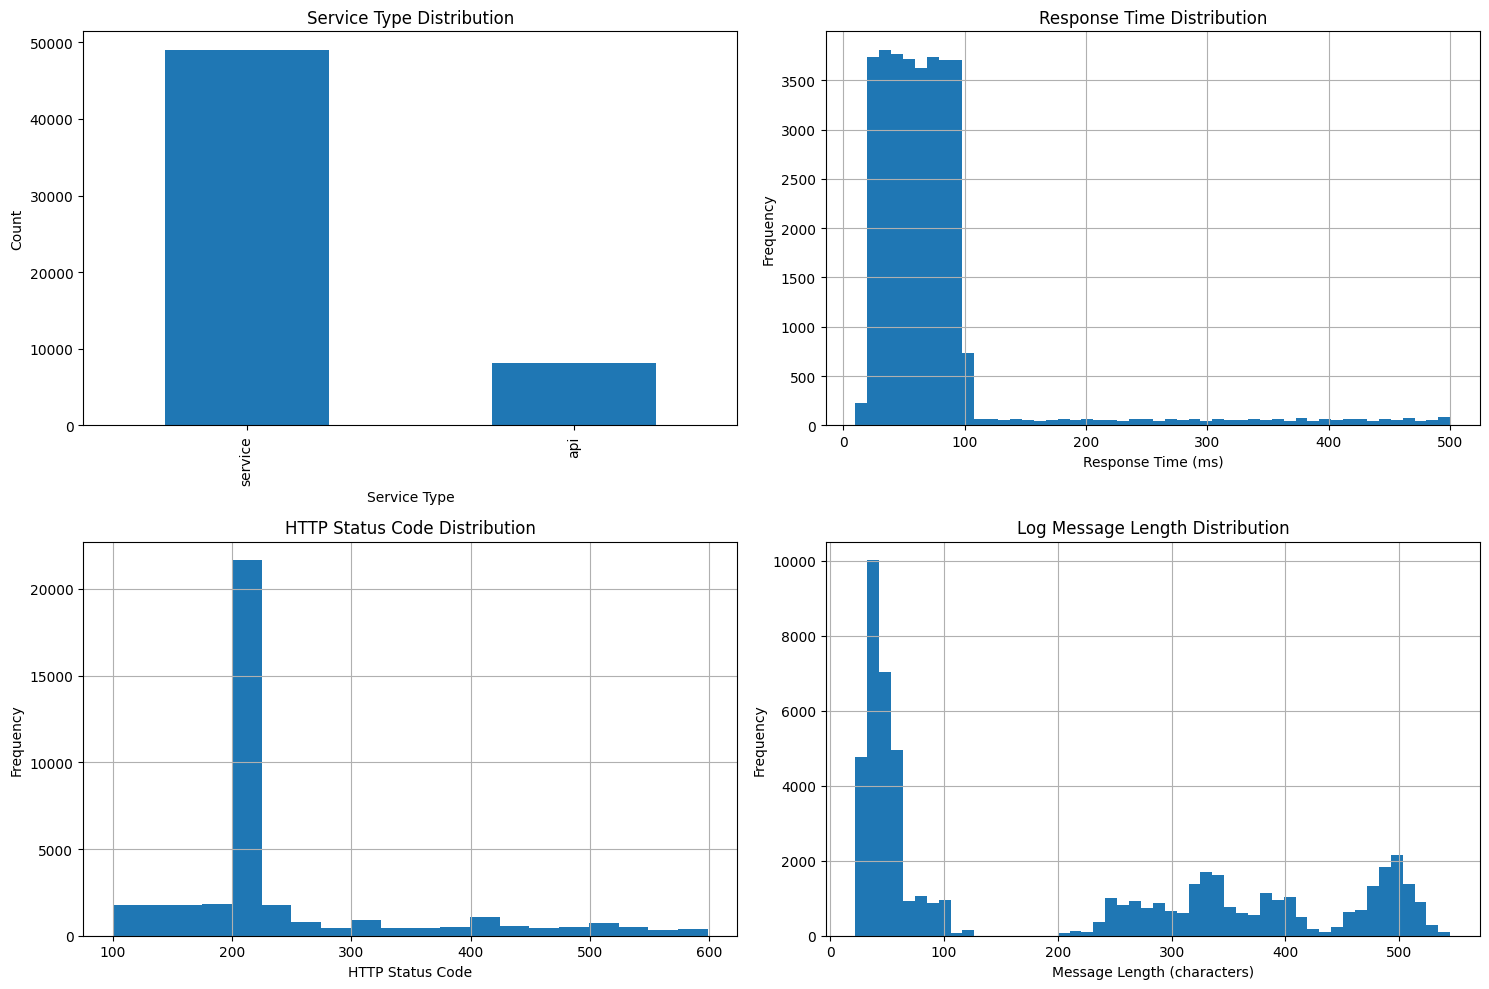

In [11]:
# Analyze new features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Service type distribution
k8s_df['service_type'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Service Type Distribution')
axes[0,0].set_xlabel('Service Type')
axes[0,0].set_ylabel('Count')

# Response time distribution
df['response_time_ms'].dropna().hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Response Time Distribution')
axes[0,1].set_xlabel('Response Time (ms)')
axes[0,1].set_ylabel('Frequency')

# HTTP status code distribution
df['http_status_code'].dropna().hist(bins=20, ax=axes[1,0])
axes[1,0].set_title('HTTP Status Code Distribution')
axes[1,0].set_xlabel('HTTP Status Code')
axes[1,0].set_ylabel('Frequency')

# Log message length distribution
df['log_message_length'].hist(bins=50, ax=axes[1,1])
axes[1,1].set_title('Log Message Length Distribution')
axes[1,1].set_xlabel('Message Length (characters)')
axes[1,1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 5. Data Validation and Quality Report

In [12]:
# Generate data quality report
def generate_quality_report(df, k8s_df):
    """Generate comprehensive data quality report"""
    
    report = {}
    
    # Basic statistics
    report['total_records'] = len(df)
    report['total_features'] = len(df.columns) + len(k8s_df.columns)
    
    # Completeness
    report['overall_completeness'] = (1 - df.isnull().sum().sum() / (df.shape[0] * df.shape[1])) * 100
    
    # Log level distribution
    report['log_level_distribution'] = df['log_level'].value_counts().to_dict()
    
    # Service type distribution
    report['service_type_distribution'] = k8s_df['service_type'].value_counts().to_dict()
    
    # Time range
    if df['parsed_timestamp'].notna().sum() > 0:
        report['time_range'] = {
            'start': str(df['parsed_timestamp'].min()),
            'end': str(df['parsed_timestamp'].max())
        }
    
    # Key metrics
    report['avg_response_time'] = df['response_time_ms'].mean() if df['response_time_ms'].notna().sum() > 0 else None
    report['unique_services'] = k8s_df['service_type'].nunique()
    report['unique_namespaces'] = k8s_df['namespace_name'].nunique()
    
    return report

quality_report = generate_quality_report(df, k8s_df)

print("=== DATA QUALITY REPORT ===")
print(f"Total records: {quality_report['total_records']:,}")
print(f"Total features: {quality_report['total_features']}")
print(f"Overall completeness: {quality_report['overall_completeness']:.2f}%")
print(f"Unique services: {quality_report['unique_services']}")
print(f"Unique namespaces: {quality_report['unique_namespaces']}")

print("\nLog level distribution:")
for level, count in quality_report['log_level_distribution'].items():
    print(f"  {level}: {count:,} ({count/quality_report['total_records']*100:.1f}%)")

print("\nService type distribution:")
for service, count in quality_report['service_type_distribution'].items():
    print(f"  {service}: {count:,} ({count/quality_report['total_records']*100:.1f}%)")

if quality_report['avg_response_time']:
    print(f"\nAverage response time: {quality_report['avg_response_time']:.2f}ms")

=== DATA QUALITY REPORT ===
Total records: 57,133
Total features: 23
Overall completeness: 94.67%
Unique services: 2
Unique namespaces: 1

Log level distribution:
  INFO: 46,141 (80.8%)
  DEBUG: 8,160 (14.3%)
  ERROR: 2,832 (5.0%)

Service type distribution:
  service: 48,993 (85.8%)
  api: 8,140 (14.2%)

Average response time: 77.03ms


## 6. Save Preprocessed Data

In [13]:
# Combine all preprocessed data
def prepare_final_dataset(df, k8s_df):
    """Prepare the final combined dataset"""
    
    # Combine main df with k8s features
    combined_df = pd.concat([df.reset_index(drop=True), k8s_df.reset_index(drop=True)], axis=1)
    
    # Select relevant columns for clustering
    feature_columns = [
        'log_level', 'response_time_ms', 'http_status_code',
        'log_message_length', 'log_word_count', 'hour', 'is_weekend',
        'service_type', 'namespace_name', 'container_name'
    ]
    
    # Create feature dataset
    feature_df = combined_df[feature_columns].copy()
    
    return combined_df, feature_df

final_df, feature_df = prepare_final_dataset(df, k8s_df)

print(f"Final dataset shape: {final_df.shape}")
print(f"Feature dataset shape: {feature_df.shape}")
print(f"\nFeature columns: {feature_df.columns.tolist()}")

# Save preprocessed data
final_df.to_csv('preprocessed_kubernetes_logs.csv', index=False)
feature_df.to_csv('features_for_clustering.csv', index=False)

print("\nPreprocessed data saved to:")
print("- preprocessed_kubernetes_logs.csv")
print("- features_for_clustering.csv")

# Display final dataset sample
print("\nFinal dataset sample:")
final_df.head()

Final dataset shape: (57133, 23)
Feature dataset shape: (57133, 10)

Feature columns: ['log_level', 'response_time_ms', 'http_status_code', 'log_message_length', 'log_word_count', 'hour', 'is_weekend', 'service_type', 'namespace_name', 'container_name']

Preprocessed data saved to:
- preprocessed_kubernetes_logs.csv
- features_for_clustering.csv

Final dataset sample:


,timestamp,stream,log,kubernetes,log_level,parsed_timestamp,hour,day_of_week,is_weekend,cleaned_log,...,log_word_count,pod_name,namespace_name,container_name,host,label_app,label_version,label_environment,label_tier,service_type
0,2024-01-01T00:00:00Z,stdout,"2024-01-01 00:00:00,000 INFO [flask.app] P...","{'pod_name': 'notification-service-1-b02c8', '...",INFO,2024-01-01 00:00:00+00:00,0,0,False,info [flask.app] put /notifications 200 49.17ms,...,6,notification-service-1-b02c8,production,notification-service,ip-35-214-27-191.b.compute.internal,notification-service,v1.3.0,production,backend,service
1,2024-01-01T00:00:00Z,stderr,"2024-01-01 00:00:00,000 INFO [app.services...","{'pod_name': 'user-service-0-152ab', 'namespac...",INFO,2024-01-01 00:00:00+00:00,0,0,False,info [app.services.user] put /users/{id}/profi...,...,6,user-service-0-152ab,production,user-service,ip-54-150-97-143.b.compute.internal,user-service,v1.8.3,production,backend,service
2,2024-01-01T00:00:00Z,stderr,2024-01-01 00:00:00 INFO PUT /orders/user/{use...,"{'pod_name': 'order-service-0-a8a76', 'namespa...",INFO,2024-01-01 00:00:00+00:00,0,0,False,info put /orders/user/{userid} 200 29.00ms,...,5,order-service-0-a8a76,production,order-service,ip-54-79-115-96.a.compute.internal,order-service,v2.1.0,production,backend,service
3,2024-01-01T00:00:00.232946Z,stderr,"2024-01-01 00:00:00,232 INFO [uvicorn.acce...","{'pod_name': 'order-service-5-11111', 'namespa...",INFO,2024-01-01 00:00:00.232946+00:00,0,0,False,info [uvicorn.access] health check passed,...,5,order-service-5-11111,production,order-service,ip-54-18-190-152.c.compute.internal,order-service,v2.1.0,production,backend,service
4,2024-01-01T00:00:00.232946Z,stdout,"{""timestamp"": ""2024-01-01T00:00:00.232946"", ""l...","{'pod_name': 'order-service-5-11111', 'namespa...",INFO,2024-01-01 00:00:00.232946+00:00,0,0,False,"{ timestamp : 2024-01-01t00:00:00.232946 , l...",...,68,order-service-5-11111,production,order-service,ip-20-11-28-76.a.compute.internal,order-service,v2.1.0,production,backend,service


## Summary

This preprocessing notebook has successfully:
1. ✅ Loaded and parsed Kubernetes logs from JSONL format
2. ✅ Performed data quality assessment and identified missing values
3. ✅ Cleaned and normalized log messages
4. ✅ Extracted structured features from Kubernetes metadata
5. ✅ Engineered additional features (service type, response time, HTTP status, etc.)
6. ✅ Generated comprehensive data quality report
7. ✅ Saved preprocessed data for subsequent clustering analysis

The preprocessed data is now ready for feature extraction and clustering analysis in the next notebooks.